In [1]:
import os

#add the root directory
os.chdir('../')

# Supplementary material: See how H2O2 and logH2O2 are distributed vs the optimized PV

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import h5py
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as cm
from loader import *

### Data

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

In [4]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = False
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


## Visualize H2O2 for different timescales

C:\Windows\Temp\ipykernel_20280\352073849.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


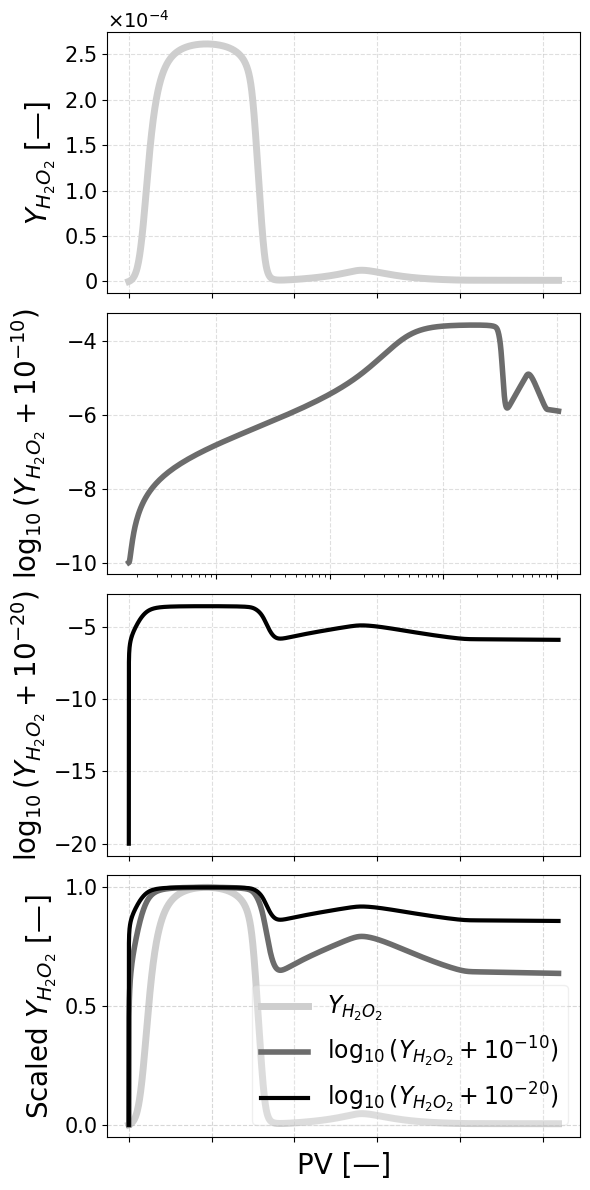

In [20]:
save = True
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Analysis-log/"
name = f"Suppl-mat-H2O2_overTime_differentScales_vs_optimizedPV"

nbr_test_trajectory = 4
rows, cols = 4,1

fig, axes = plt.subplots(rows, cols, figsize=(6, 12))  # Define the grid
axes = axes.flatten()

species_to_inspect = ['H2O2']
idx_species = 0
species_label = species_to_inspect[idx_species].replace("2", "_{2}")

greys = cm.get_cmap('Greys')

addLogArray = [0, 1e-10, 1e-20]
linewidthArray = [5, 4, 3]
greyArray = [greys(0.3), greys(0.65), "k"]
zorderArray = [1, 2, 3]

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{nbr_test_trajectory}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
    PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[nbr_test_trajectory]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))

#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{nbr_test_trajectory}'][:]).to_numpy()

# remove first point which has t=0s
test_trajectory_time_nonzero = test_trajectory_time[test_trajectory_time > 0]
test_trajectory_nonzero = test_trajectory[test_trajectory_time > 0]
PV_optimized_test_nonzero = PV_optimized_test[test_trajectory_time > 0]

class ScalarFormatterZero(ticker.ScalarFormatter):
    def __call__(self, x, pos=None):
        if x == 0:
            return "0"
        return super().__call__(x, pos)
    
for idxFig in range((rows-1)*cols):

    addLog = addLogArray[idxFig]

    if(addLog == 0):
        speciesTraj = test_trajectory_nonzero[species_to_inspect[idx_species]]
    elif(addLog > 0):
        speciesTraj = np.log10(test_trajectory_nonzero[species_to_inspect[idx_species]] + addLog)
    
    ax = axes[idxFig]
    ax.plot(PV_optimized_test_nonzero, speciesTraj, color = greyArray[idxFig], linewidth = linewidthArray[idxFig])

    if(idxFig%2 == 0 and idxFig>=(rows-1)*cols):
        ax.set_xlabel("t [s]", fontsize = 15)
    elif((idxFig+1)%2 == 0):
        ax.set_xscale("log")
        if(idxFig>=(rows-1)*cols):
            ax.set_xlabel("$\log_{10}(t)$ [s]", fontsize = 15)
        else:
            ax.set_xticklabels([])
    else:
            ax.set_xticklabels([])

    if(idxFig%cols == 0):
        if(idxFig < cols):
            ax.set_ylabel(f"$Y_{{{species_label}}}$ [\u2014]", fontsize = 20)
        else:
            ax.set_ylabel(f"$\log_{{{10}}}(Y_{{{species_label}}} + 10^{{{int(np.log10(addLog))}}})$", fontsize = 20)
    else:
        ax.set_yticklabels([])

    ax.tick_params(axis='y', labelsize=15)
    ax.grid(True, linestyle='--', alpha=0.4)

    if idxFig in [0]:
        formatter = ScalarFormatterZero(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-4, -4))   # force ×10⁻⁴

        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.get_offset_text().set_size(14)

legend_handles = []

for idxFig in range(rows-1):

    addLog = addLogArray[idxFig]

    if(addLog == 0):
        speciesTraj = test_trajectory_nonzero[species_to_inspect[idx_species]]
        
    elif(addLog > 0):
        speciesTraj = np.log10(test_trajectory_nonzero[species_to_inspect[idx_species]] + addLog)

    speciesTraj_scaled = (speciesTraj - speciesTraj.min())/(speciesTraj.max() - speciesTraj.min())

    ax = axes[3]
    line, = ax.plot(PV_optimized_test_nonzero, speciesTraj_scaled, c = greyArray[idxFig], linewidth = linewidthArray[idxFig], zorder = zorderArray[idxFig])
    ax.set_yticks([0, 0.5, 1])
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)

    if(idxFig%2 == 0):
        ax.set_xlabel("PV [\u2014]", fontsize = 20)
    else:
            ax.set_xticklabels([])

    if idxFig == 0:
            label = f"$Y_{{{species_label}}}$"
    else:
        log_offset = int(np.log10(addLog))
        label = f"$\log_{{10}}(Y_{{{species_label}}} + 10^{{{log_offset}}})$"
    legend_handles.append((line, label))
    
    if(idxFig%cols == 0):
        ax.set_ylabel(f"Scaled $Y_{{{species_label}}}$ [\u2014]", fontsize = 20)
    else:
        ax.set_yticklabels([])

    ax.grid(True, linestyle='--', alpha=0.5)

if legend_handles:
    handles, labels = zip(*legend_handles)
    legend = axes[3].legend(handles, labels, fontsize=17, loc="lower right", frameon=True)
    legend.get_frame().set_alpha(0.3)

plt.tight_layout()
if(save):
    plt.savefig(pathSave + name + ".png", dpi=1000, bbox_inches = "tight")
    plt.savefig(pathSave + name + ".pdf", bbox_inches = "tight")

plt.show()